# **EE4C12-Epileptic-Seizure-Detection-using-EEG**


    
Group 16 Members:

    1. Zhixuan Ge  
    2. Yanqi Hong 

## **1. **Program Preparation****

### 1.1 Import Packages

In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_curve, precision_recall_curve, PrecisionRecallDisplay, roc_auc_score, RocCurveDisplay, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
import random
#from kmeans_pytorch import kmeans, kmeans_predict
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
device = "cuda"
#device = "cpu"

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

### 1.2 Import Data

In [4]:
# #load data on Yanqi Hong's computer
# data = pd.read_csv('E:\DATA\TUD\Master\TUD_Master_Y1\Q1\EE4C12 Machine Learning For Electrical Engineering\CodeLab\Project\S&S_SZD (1)\Data\Project_Data_EE4C12_S&S_SZD.csv')
# data

In [5]:
# load data on Zhixuan's computer
data = pd.read_csv('D:\\User\Zhixuan Ge\Onedrive TUDelft\OneDrive - Delft University of Technology\Courses\ML for EE\SZD\S&S_SZD\Project_Data_EE4C12_S&S_SZD.csv')
data

,Patient,annotation,min|FP1-F7,min|F7-T3,min|T3-T5,min|T5-O1,min|FP2-F8,min|F8-T4,min|T4-T6,min|T6-O2,...,norm_power_HF|CZ-C4,norm_power_HF|C4-T4,norm_power_HF|FP1-F3,norm_power_HF|F3-C3,norm_power_HF|C3-P3,norm_power_HF|P3-O1,norm_power_HF|FP2-F4,norm_power_HF|F4-C4,norm_power_HF|C4-P4,norm_power_HF|P4-O2
0,258,1,50,61,57,53,39,35,39,35,...,0.016087,0.066920,0.102402,0.481384,0.690787,0.154544,0.062533,0.046460,0.066575,0.086999
1,258,1,48,62,60,46,38,35,39,33,...,0.024006,0.064857,0.031791,0.225788,0.409987,0.184671,0.071133,0.022369,0.079494,0.047536
2,258,1,51,60,59,45,38,36,40,36,...,0.037326,0.100177,0.050009,0.622584,0.394504,0.225516,0.050673,0.044906,0.102142,0.068105
3,258,1,49,58,56,42,36,36,41,37,...,0.027546,0.107883,0.014017,0.359140,0.276964,0.104977,0.018042,0.079467,0.078255,0.089385
4,258,1,45,57,61,41,35,37,41,37,...,0.036820,0.182520,0.031397,0.328354,0.156929,0.151952,0.047532,0.135071,0.098320,0.137701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55451,11580,-1,75,73,81,80,66,80,77,75,...,0.244334,0.625396,0.023821,0.058277,0.083594,0.114426,0.119654,0.295364,0.185930,0.199585
55452,11580,-1,74,74,77,71,79,75,82,77,...,0.588236,0.743060,0.076294,0.332341,0.228458,0.170603,0.351418,0.638666,0.490806,0.307429
55453,11580,-1,72,76,72,73,74,76,80,76,...,0.296041,0.770194,0.041190,0.090919,0.186074,0.216797,0.231053,0.770637,0.285257,0.413382
55454,11580,-1,77,82,74,75,82,85,80,76,...,0.440360,0.720855,0.026959,0.026340,0.077674,0.269610,0.186769,0.790173,0.473615,0.415771


## **2. Data Preprocessing**

### 2.1 Train-Test Split

In [6]:

# x is the features, y is the label
y = np.int32(data['annotation'].values) 
X = data.iloc[:, 2:].values # the first two columns are patient ID and annotation, which are not features


#split the data into training and testing
Shuffle_state = 42
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=Shuffle_state)

print(X_train.shape)
print(X_test.shape)

classification_lable = [-1,0,1] # 1 stands for seizure segment, -1 stand for non-seizure segment. 0 stands for a segment that is right at the beginning or end of a seizure

(41592, 360)
(13864, 360)


### 2.2 Scaling

In [7]:
#standardize the data
scaler = StandardScaler().fit(X_train)  # fit the scaler to the training data
X_train_scaled = scaler.transform(X_train)  # transform the training data
X_test_scaled = scaler.transform(X_test)    # transform the testing data



### 2.3 Feature Selection

The original number of training feature is:  360


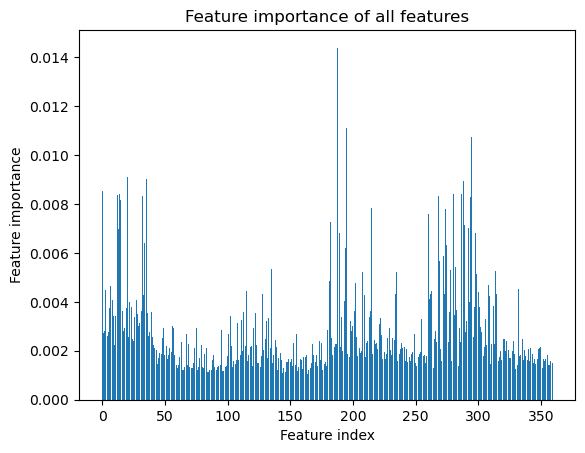

The current number of training feature after feature selection is:  120


In [8]:
print("The original number of training feature is: ", X_train_scaled.shape[1])
clf_etc = ExtraTreesClassifier(random_state=Shuffle_state).fit(X_train_scaled, y_train) # fit the model
feature_importances = clf_etc.feature_importances_  # get the feature importance

plt.bar(range(len(feature_importances)), feature_importances)   # plot the feature importance
plt.xlabel("Feature index")
plt.ylabel("Feature importance")
plt.title("Feature importance of all features")
plt.show()

important_feature_indices=np.argsort(feature_importances)   # sort the feature importance  
important_feature_indices_cut=important_feature_indices[:int(len(important_feature_indices)/1.5)]   # select the most important features  

X_train_scaled=np.delete(X_train_scaled,important_feature_indices_cut,1)    # delete the least important features
X_test_scaled=np.delete(X_test_scaled,important_feature_indices_cut,1)      # delete the least important features
print("The current number of training feature after feature selection is: ", X_train_scaled.shape[1])

### 2.4 Oversampling and Undersampling

In [9]:
num_zero=np.sum(y_train==0)
num_one=np.sum(y_train==1)
num_negatives_one=np.sum(y_train==-1)
print('The original sample number of 0 is', num_zero)
print('The original sample number of 1 is', num_one)
print('The original sample number of -1 is', num_negatives_one)

# oversampling
sm = SMOTE(random_state=Shuffle_state)
X_train_scaled, y_train = sm.fit_resample(X_train_scaled, y_train)

num_zero=np.sum(y_train==0)
num_one=np.sum(y_train==1)
num_negatives_one=np.sum(y_train==-1)

print('')
print('The current sample number of 0 is', num_zero)
print('The current sample number of 1 is', num_one)
print('The current sample number of -1 is', num_negatives_one)

The original sample number of 0 is 1469
The original sample number of 1 is 18177
The original sample number of -1 is 21946

The current sample number of 0 is 21946
The current sample number of 1 is 21946
The current sample number of -1 is 21946


## **3. **Model Training, validation and evaluation****

### 3.1 Logistic regression model

#### 3.1.1 Model training and validation

In [31]:
#Logistic regression
# random search to find the best hyperparameters
clf_lr = LogisticRegression(max_iter=1000,class_weight="balanced")  # define the model
param_dist = {'C':np.arange(-4, 4, 0.5), 'penalty':['l1', 'l2']}    # define the hyperparameters

# run randomized search
n_iter_search = 10
random_search = RandomizedSearchCV(clf_lr, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, verbose=2, n_jobs=12) 
random_search.fit(X_train_scaled, y_train)


best_params = random_search.best_params_
best_score = random_search.best_score_
print("the best parameters are",random_search.best_params_)
print("Best score:", random_search.best_score_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
45 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py", line 1160, in fit
    self._validate_params()
  File "C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py", line 600, in _validate_params
   

the best parameters are {'penalty': 'l2', 'C': 1.0}
Best score: 0.6947203595257889


#### 3.1.2 Model validation result

The accuracy score of the 1 th fold is 0.6928159173754557
The accuracy score of the 2 th fold is 0.6957776427703524
The accuracy score of the 3 th fold is 0.6903857837181046
The accuracy score of the 4 th fold is 0.7019062808536493
The accuracy score of the 5 th fold is 0.69377990430622
+------------------------------------------------------+
The mean of the accuracy score is 0.6949331058047564
+------------------------------------------------------+


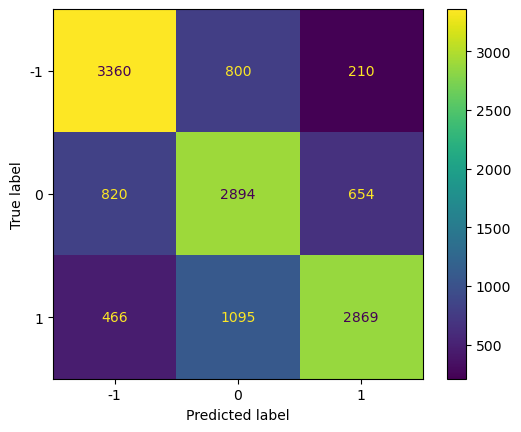

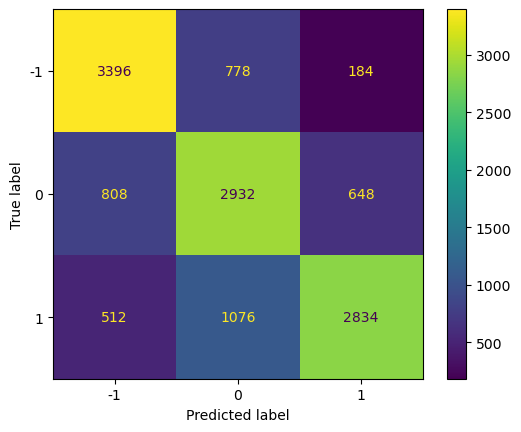

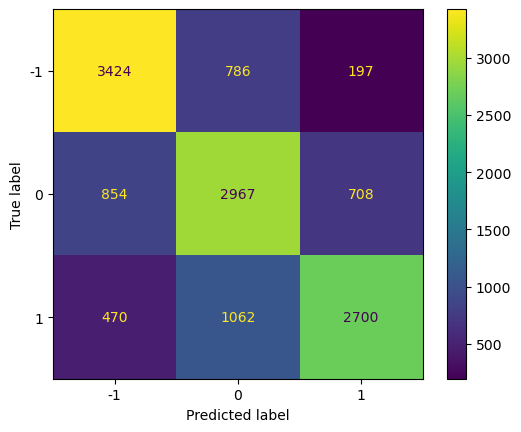

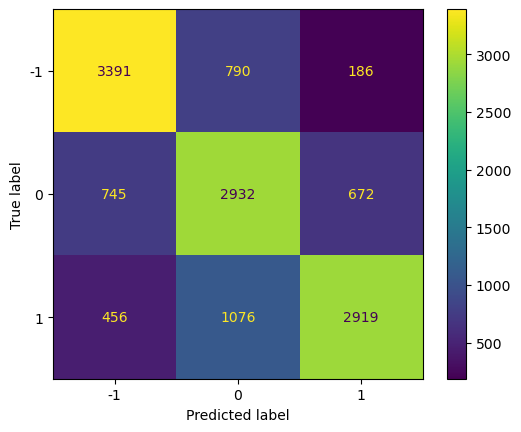

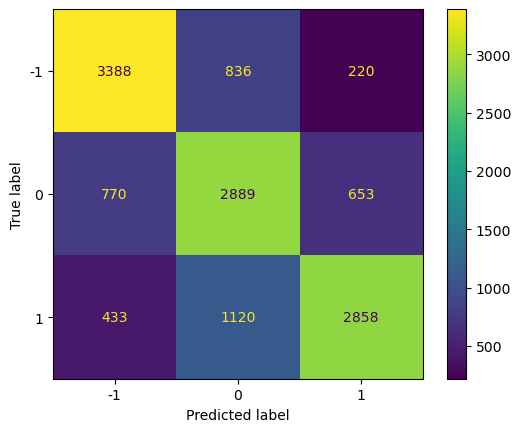

In [32]:
clf_lr = LogisticRegression(max_iter=1000,class_weight="balanced",C=best_params['C'],penalty=best_params['penalty'])  # define the model

# 5-fold cross validation
X_k_train_list, y_k_train_list, X_k_val_list, y_k_val_list = Kfold_split(X_train_scaled, y_train, Shuffle_state)
accuracy_score_list = []

for i in range(len(X_k_train_list)):
    clf_lr.fit(X_k_train_list[i], y_k_train_list[i])
    y_pred = clf_lr.predict(X_k_val_list[i])
    accuracy_score_list.append(accuracy_score(y_k_val_list[i], y_pred))

    print("The accuracy score of the", i+1, "th fold is", accuracy_score_list[i])
    
    #plot the confusion matrix
    cm = confusion_matrix(y_k_val_list[i], y_pred, labels=classification_lable)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classification_lable) 
    disp.plot()

accuracy_score_mean = np.mean(accuracy_score_list)

print("+------------------------------------------------------+")
print("The mean of the accuracy score is", accuracy_score_mean)
print("+------------------------------------------------------+")



#### 3.1.3 Model evaluation

In [33]:
y_pred = clf_lr.predict(X_test_scaled)
#Performance metrics
Accuracy_LR = accuracy_score(y_test, y_pred)
F1_LR = accuracy_score(y_test, y_pred)
Precision_LR = accuracy_score(y_test, y_pred)
Recall_LR = accuracy_score(y_test, y_pred)
print("Accuracy: " + str(Accuracy_LR))
print("F1 score: " + str(F1_LR))
print("Recall score: " + str(Recall_LR))
print("Precision score: " + str(Precision_LR))

Accuracy: 0.7135747259088286
F1 score: 0.7135747259088286
Recall score: 0.7135747259088286
Precision score: 0.7135747259088286


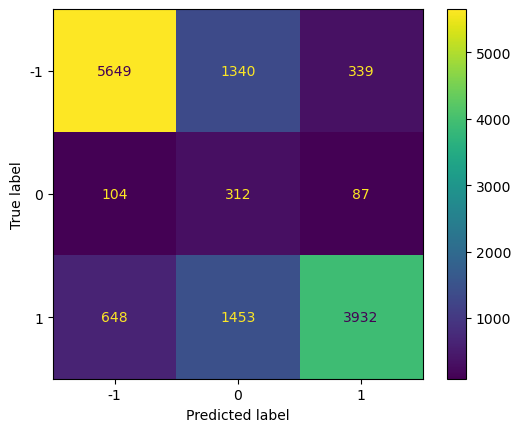

In [34]:
#Confusion Matrix
cm_2c = confusion_matrix(y_test, y_pred)
cm_display_2c = ConfusionMatrixDisplay(cm_2c, display_labels=classification_lable).plot()
plt.show()

#### 3.1.4 Model summary

In [35]:
#linear regression summary
print("-----------------Logistic Regression Summary-----------------")
print("Best parameters:", best_params)
print("Best score in cross validation process:", best_score)
print("Accuracy in validation set with best parameters: " + str(accuracy_score_mean))
print("Accuracy in test set with best parameters: " + str(Accuracy_LR))
print("-------------------------------------------------------------")

-----------------Logistic Regression Summary-----------------
Best parameters: {'penalty': 'l2', 'C': 1.0}
Best score in cross validation process: 0.6947203595257889
Accuracy in validation set with best parameters: 0.6949331058047564
Accuracy in test set with best parameters: 0.7135747259088286
-------------------------------------------------------------


### 3.2 SVM model

#### 3.2.1 Model training and validation

In [36]:
#SVM
# random search to find the best hyperparameters
clf_svm = svm.SVC(max_iter=1000,class_weight="balanced")  # define the model
param_dist = {'C':np.arange(-4, 4, 0.5), 'kernel':['linear', 'poly', 'rbf', 'sigmoid'], 'degree':np.arange(1, 5, 1), 'gamma':['scale', 'auto']}

# # run randomized search
n_iter_search = 10
random_search = RandomizedSearchCV(clf_svm, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, verbose=2, n_jobs=12) 
random_search.fit(X_train_scaled, y_train)
y_pred = random_search.predict(X_test_scaled)

best_params = random_search.best_params_
best_score = random_search.best_score_
print("the best parameters are",random_search.best_params_)
print("Best score:", random_search.best_score_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
35 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_base.py", line 180, in fit
    self._validate_params()
  File "C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py", line 600, in _validate_params
    validate_para

the best parameters are {'kernel': 'linear', 'gamma': 'auto', 'degree': 1, 'C': 1.5}
Best score: 0.3749066886905027


#### 3.2.2 Model validation result

C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


The accuracy score of the 1 th fold is 0.4265643985419198


C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


The accuracy score of the 2 th fold is 0.3457624544349939


C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


The accuracy score of the 3 th fold is 0.34097812879708383


C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


The accuracy score of the 4 th fold is 0.45112781954887216


C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


The accuracy score of the 5 th fold is 0.3923444976076555
+------------------------------------------------------+
The mean of the accuracy score is 0.39135545978610503
+------------------------------------------------------+


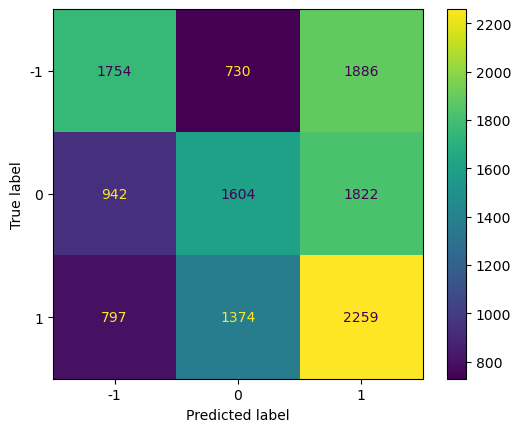

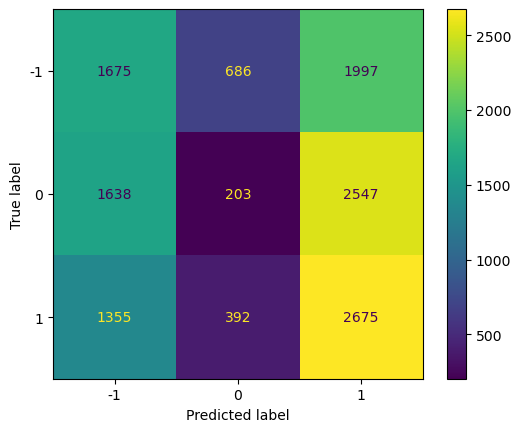

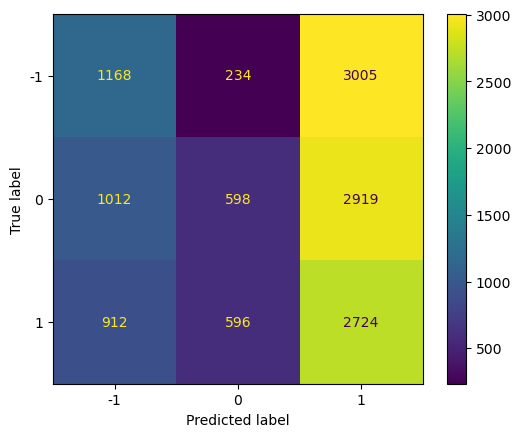

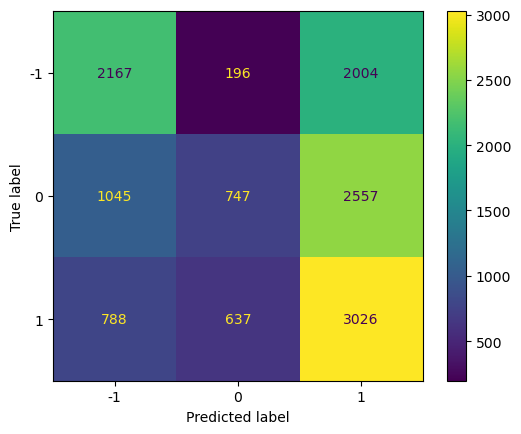

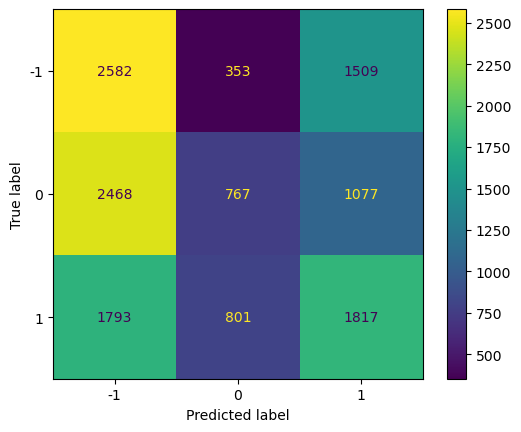

In [37]:
clf_svm = svm.SVC(max_iter=1000,class_weight="balanced",C=best_params['C'],kernel=best_params['kernel'],degree=best_params['degree'],gamma=best_params['gamma'])  # define the model

# 5-fold cross validation
X_k_train_list, y_k_train_list, X_k_val_list, y_k_val_list = Kfold_split(X_train_scaled, y_train, Shuffle_state)
accuracy_score_list = []

for i in range(len(X_k_train_list)):
    clf_svm.fit(X_k_train_list[i], y_k_train_list[i])
    y_pred = clf_svm.predict(X_k_val_list[i])
    accuracy_score_list.append(accuracy_score(y_k_val_list[i], y_pred))

    print("The accuracy score of the", i+1, "th fold is", accuracy_score_list[i])
    
    #plot the confusion matrix
    cm = confusion_matrix(y_k_val_list[i], y_pred, labels=classification_lable)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classification_lable) 
    disp.plot()

accuracy_score_mean = np.mean(accuracy_score_list)

print("+------------------------------------------------------+")
print("The mean of the accuracy score is", accuracy_score_mean)
print("+------------------------------------------------------+")


#### 3.2.2 Model evaluation

In [38]:
y_pred = clf_svm.predict(X_test_scaled)

#Performance metrics
Accuracy_LR = accuracy_score(y_test, y_pred)
F1_LR = accuracy_score(y_test, y_pred)
Precision_LR = accuracy_score(y_test, y_pred)
Recall_LR = accuracy_score(y_test, y_pred)
print("Accuracy: " + str(Accuracy_LR))
print("F1 score: " + str(F1_LR))
print("Recall score: " + str(Recall_LR))
print("Precision score: " + str(Precision_LR))

Accuracy: 0.4960328909405655
F1 score: 0.4960328909405655
Recall score: 0.4960328909405655
Precision score: 0.4960328909405655


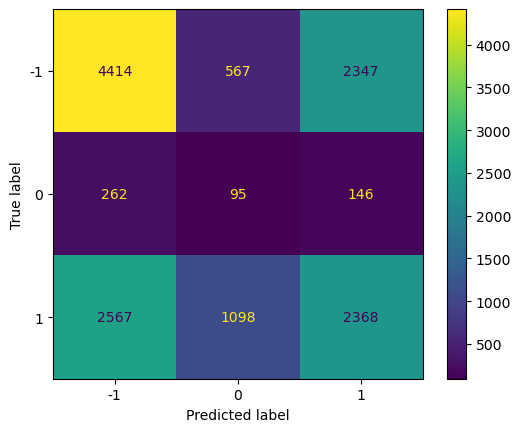

In [39]:
#Confusion Matrix
cm_2c = confusion_matrix(y_test, y_pred)
cm_display_2c = ConfusionMatrixDisplay(cm_2c, display_labels=classification_lable).plot()
plt.show()

#### 3.2.3 Model summary

In [40]:
#svm summary
print("-----------------SVM Summary-----------------")
print("Best parameters:", best_params)
print("Best score in cross validation process:", best_score)
print("Accuracy in validation set with best parameters: " + str(accuracy_score_mean))
print("Accuracy in test set with best parameters: " + str(Accuracy_LR))
print("-------------------------------------------------------------")


-----------------SVM Summary-----------------
Best parameters: {'kernel': 'linear', 'gamma': 'auto', 'degree': 1, 'C': 1.5}
Best score in cross validation process: 0.3749066886905027
Accuracy in validation set with best parameters: 0.39135545978610503
Accuracy in test set with best parameters: 0.4960328909405655
-------------------------------------------------------------


### 3.3 MLP model (based on sklearn)


#### 3.3.1 Model training and validation

In [41]:
min_width=32
max_width=256
min_depth=1
max_depth=3
hidden_layer_number=5

min_learning_rate=0.0001
max_learning_rate=0.01
learning_rate_number=3

mlp = MLPClassifier()
param_dist = {"hidden_layer_sizes": [tuple([randint(min_width,max_width).rvs() for i in range(randint(min_depth, max_depth+1).rvs())]) for j in range(hidden_layer_number)],
              "activation": ["logistic", "tanh", "relu"],
              "alpha": [randint(int(min_learning_rate*10000),int(max_learning_rate*10000)).rvs()/10000  for j in range(learning_rate_number)],
            }
print(param_dist)

# run randomized search
n_iter_search = 10
random_search = RandomizedSearchCV(mlp, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, verbose=2, n_jobs=10)
random_search.fit(X_train_scaled, y_train)


best_params = random_search.best_params_
best_score = random_search.best_score_
print("the best parameters are",random_search.best_params_)
print("Best score:", random_search.best_score_)

{'hidden_layer_sizes': [(114, 120), (162, 72, 230), (178, 180, 162), (223, 133, 126), (194,)], 'activation': ['logistic', 'tanh', 'relu'], 'alpha': [0.0017, 0.0021, 0.0014]}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
the best parameters are {'hidden_layer_sizes': (223, 133, 126), 'alpha': 0.0017, 'activation': 'relu'}
Best score: 0.9366780430955144


#### 3.3.2 Model validation result

The accuracy score of the 1 th fold is 0.9340066828675577
The accuracy score of the 2 th fold is 0.9413730255164034
The accuracy score of the 3 th fold is 0.9374240583232077
The accuracy score of the 4 th fold is 0.938102832839675
The accuracy score of the 5 th fold is 0.9321789321789322
+------------------------------------------------------+
The mean of the accuracy score is 0.9366171063451553
+------------------------------------------------------+


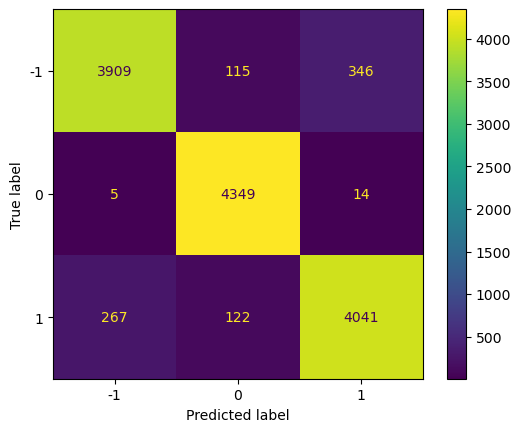

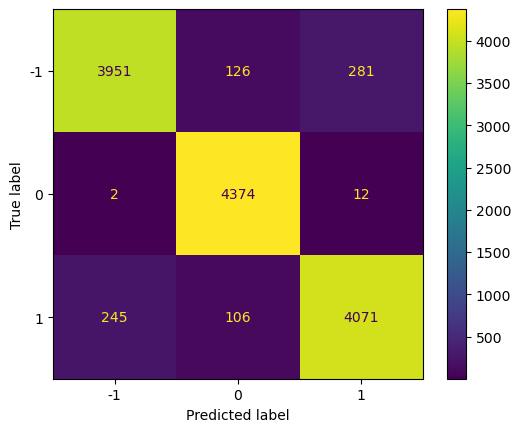

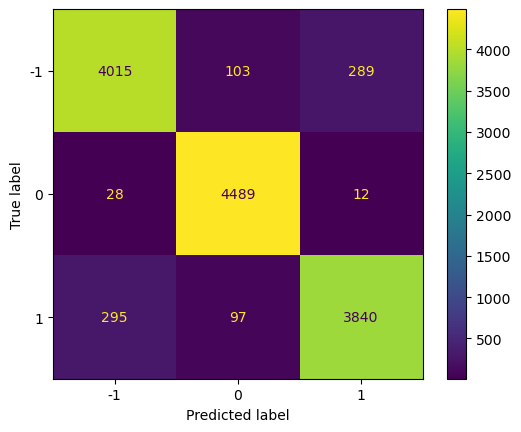

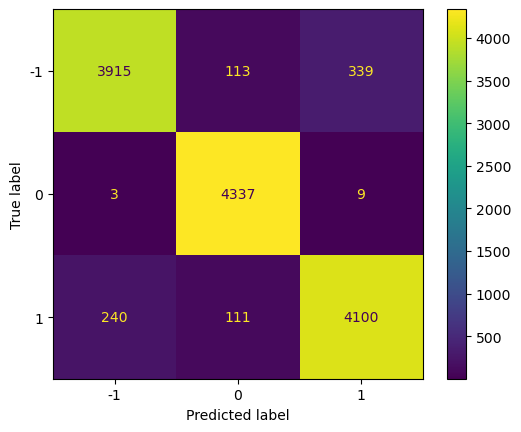

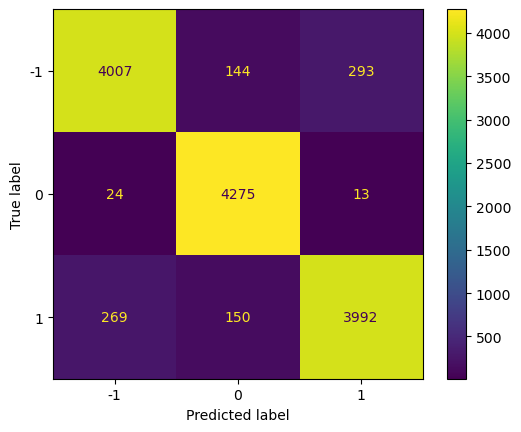

In [42]:

mlp = MLPClassifier(hidden_layer_sizes=best_params['hidden_layer_sizes'],activation=best_params['activation'],alpha=best_params['alpha'])  # define the model

# 5-fold cross validation
X_k_train_list, y_k_train_list, X_k_val_list, y_k_val_list = Kfold_split(X_train_scaled, y_train, Shuffle_state)
accuracy_score_list = []

for i in range(len(X_k_train_list)):
    mlp.fit(X_k_train_list[i], y_k_train_list[i])
    y_pred = mlp.predict(X_k_val_list[i])
    accuracy_score_list.append(accuracy_score(y_k_val_list[i], y_pred))

    print("The accuracy score of the", i+1, "th fold is", accuracy_score_list[i])
    
    #plot the confusion matrix
    cm = confusion_matrix(y_k_val_list[i], y_pred, labels=classification_lable)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classification_lable) 
    disp.plot()

accuracy_score_mean = np.mean(accuracy_score_list)

print("+------------------------------------------------------+")
print("The mean of the accuracy score is", accuracy_score_mean)
print("+------------------------------------------------------+")


#### 3.3.2 Model evaluation

In [43]:
y_pred = mlp.predict(X_test_scaled)
#Performance metrics
Accuracy_LR = accuracy_score(y_test, y_pred)
F1_LR = accuracy_score(y_test, y_pred)
Precision_LR = accuracy_score(y_test, y_pred)
Recall_LR = accuracy_score(y_test, y_pred)
print("Accuracy: " + str(Accuracy_LR))
print("F1 score: " + str(F1_LR))
print("Recall score: " + str(Recall_LR))
print("Precision score: " + str(Precision_LR))

Accuracy: 0.8647576457010964
F1 score: 0.8647576457010964
Recall score: 0.8647576457010964
Precision score: 0.8647576457010964


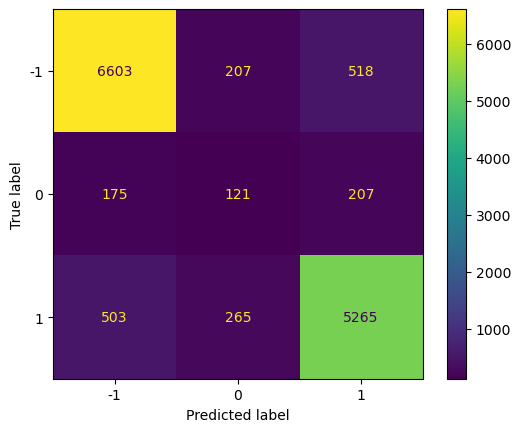

In [44]:
#Confusion Matrix
cm_2c = confusion_matrix(y_test, y_pred)
cm_display_2c = ConfusionMatrixDisplay(cm_2c, display_labels=classification_lable).plot()
plt.show()


#### 3.3.3 Model summary

In [45]:
# mlp summary
print("-----------------MLP Summary-----------------")
print("Best parameters:", best_params)
print("Best score in cross validation process:", best_score)
print("Accuracy in validation set with best parameters: " + str(accuracy_score_mean))
print("Accuracy in test set best parameters: " + str(Accuracy_LR))
print("-------------------------------------------------------------")


-----------------MLP Summary-----------------
Best parameters: {'hidden_layer_sizes': (223, 133, 126), 'alpha': 0.0017, 'activation': 'relu'}
Best score in cross validation process: 0.9366780430955144
Accuracy in validation set with best parameters: 0.9366171063451553
Accuracy in test set best parameters: 0.8647576457010964
-------------------------------------------------------------


### 3.4 Random Forest

#### 3.4.1 Model training and validation

In [50]:
rf = RandomForestClassifier()
param_dist = {"max_depth": [3,4,5,None],
              "max_features": ["sqrt", "log2", None],
              "min_samples_split": np.arange(2, 10),
              "criterion": ["gini", "entropy", "log_loss"]}

# run randomized search
n_iter_search = 10
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, verbose=3, n_jobs=8)

random_search.fit(X_train_scaled, y_train)  # fit the model

best_params = random_search.best_params_
best_score = random_search.best_score_
print("the best parameters are",best_params)
print("Best score:", best_score)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


the best parameters are {'min_samples_split': 3, 'max_features': 'log2', 'max_depth': None, 'criterion': 'entropy'}
Best score: 0.930587311830517


#### 3.4.2 Model validation result

The accuracy score of the 1 th fold is 0.9277794653705954
The accuracy score of the 2 th fold is 0.9302855407047388
The accuracy score of the 3 th fold is 0.9316524908869988
The accuracy score of the 4 th fold is 0.9251917672970305
The accuracy score of the 5 th fold is 0.9279258752942964
+------------------------------------------------------+
The mean of the accuracy score is 0.928567027910732
+------------------------------------------------------+


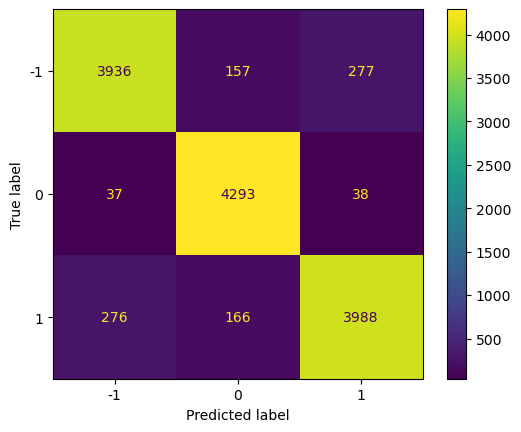

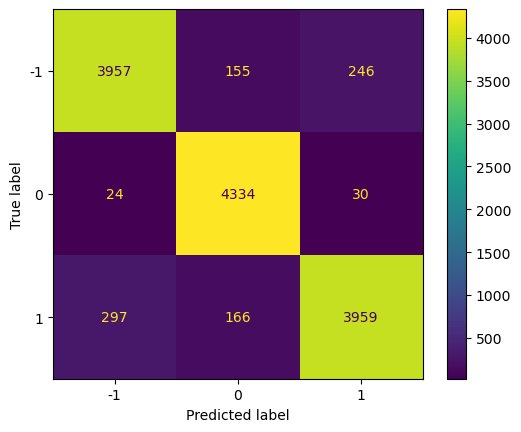

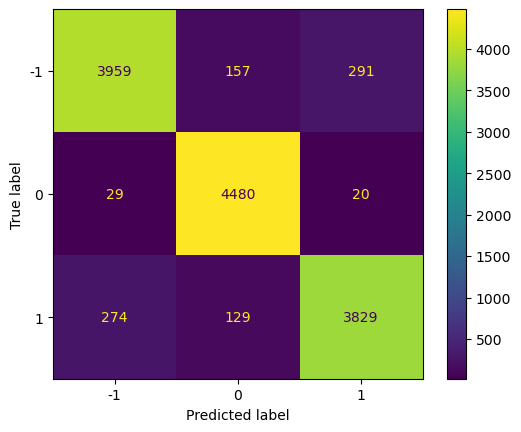

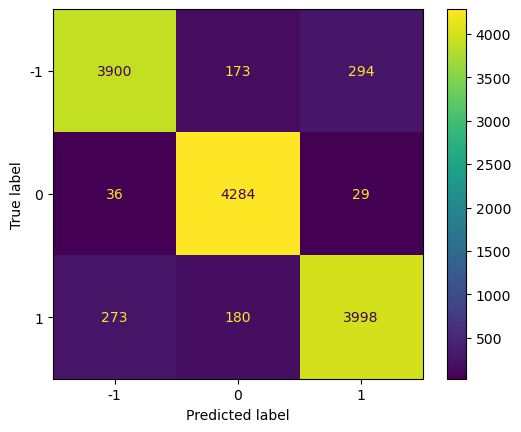

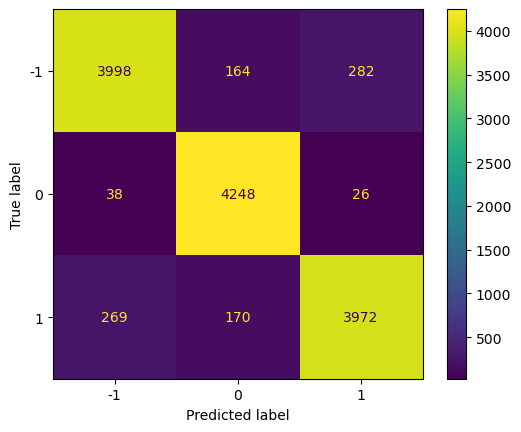

In [51]:

rf = RandomForestClassifier(max_depth=best_params['max_depth'],max_features=best_params['max_features'],min_samples_split=best_params['min_samples_split'],criterion=best_params['criterion'])  # define the model

# 5-fold cross validation
X_k_train_list, y_k_train_list, X_k_val_list, y_k_val_list = Kfold_split(X_train_scaled, y_train, Shuffle_state)
accuracy_score_list = []

for i in range(len(X_k_train_list)):
    rf.fit(X_k_train_list[i], y_k_train_list[i])
    y_pred = rf.predict(X_k_val_list[i])
    accuracy_score_list.append(accuracy_score(y_k_val_list[i], y_pred))

    print("The accuracy score of the", i+1, "th fold is", accuracy_score_list[i])
    
    #plot the confusion matrix
    cm = confusion_matrix(y_k_val_list[i], y_pred, labels=classification_lable)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classification_lable) 
    disp.plot()

accuracy_score_mean = np.mean(accuracy_score_list)

print("+------------------------------------------------------+")
print("The mean of the accuracy score is", accuracy_score_mean)
print("+------------------------------------------------------+")


#### 3.4.2 Model evaluation

In [52]:
y_pred = rf.predict(X_test_scaled)
#Performance metrics
Accuracy_LR = accuracy_score(y_test, y_pred)
F1_LR = accuracy_score(y_test, y_pred)
Precision_LR = accuracy_score(y_test, y_pred)
Recall_LR = accuracy_score(y_test, y_pred)
print("Accuracy: " + str(Accuracy_LR))
print("F1 score: " + str(F1_LR))
print("Recall score: " + str(Recall_LR))
print("Precision score: " + str(Precision_LR))

Accuracy: 0.8645412579342181
F1 score: 0.8645412579342181
Recall score: 0.8645412579342181
Precision score: 0.8645412579342181


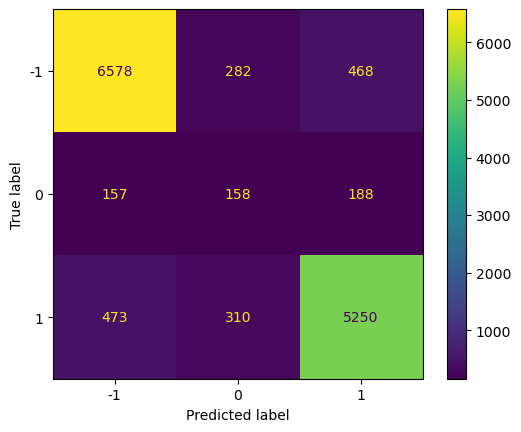

In [53]:
#Confusion Matrix
cm_2c = confusion_matrix(y_test, y_pred)
cm_display_2c = ConfusionMatrixDisplay(cm_2c, display_labels=classification_lable).plot()
plt.show()

#### 3.4.3 Model summary

In [54]:
# random forest summary
print("-----------------Random Forest Summary-----------------")
print("Best parameters:", best_params)
print("Best score in cross validation process:", best_score)
print("Accuracy in validation set with best parameters: " + str(accuracy_score_mean))
print("Accuracy in test set with best parameters: " + str(Accuracy_LR))
print("-------------------------------------------------------------")


-----------------Random Forest Summary-----------------
Best parameters: {'min_samples_split': 3, 'max_features': 'log2', 'max_depth': None, 'criterion': 'entropy'}
Best score in cross validation process: 0.930587311830517
Accuracy in validation set with best parameters: 0.928567027910732
Accuracy in test set with best parameters: 0.8645412579342181
-------------------------------------------------------------


### 3.4  DNN model (based on PyTorch)

#### 3.4.1 Model definition

In [11]:
# initialize the NN
class Data_tensor(Dataset):
    def __init__(self, X, y):
        X = np.float32(X)
        X = torch.from_numpy(X)
        y = np.longlong(y) - y.min()
        y = torch.from_numpy(y)
        
        self.X = X.to(device)
        self.y = y.to(device)
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    


In [12]:
# DNN class for random search
class DNN_rs(nn.Module):
    # Available activation functions: ReLU, Sigmoid, Tanh, LeakyReLU, ELU, SELU, Softplus, Softsign, LogSigmoid, PReLU, Softmin, Softmax, if the input is not in the list, ReLU will be used
    def __init__(self, input_size, hidden_sizes, output_size, activition_layer=nn.ReLU()):
        super(DNN_rs, self).__init__()
        depth=len(hidden_sizes)
        layers = []
        for i in range(depth):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_sizes[i])) 
            else:
                layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            if activition_layer=="ReLU":
                layers.append(nn.ReLU())
            elif activition_layer=="Sigmoid":
                layers.append(nn.Sigmoid())
            elif activition_layer=="Tanh":
                layers.append(nn.Tanh())
            elif activition_layer=="LeakyReLU":
                layers.append(nn.LeakyReLU())
            elif activition_layer=="ELU":
                layers.append(nn.ELU())
            elif activition_layer=="SELU":
                layers.append(nn.SELU())
            elif activition_layer=="Softplus":
                layers.append(nn.Softplus())
            elif activition_layer=="Softsign":
                layers.append(nn.Softsign())
            elif activition_layer=="LogSigmoid":
                layers.append(nn.LogSigmoid())
            elif activition_layer=="PReLU":
                layers.append(nn.PReLU())
            elif activition_layer=="Softmin":
                layers.append(nn.Softmin())
            elif activition_layer=="Softmax":
                layers.append(nn.Softmax())
            else:
                layers.append(nn.ReLU())
        layers.append(nn.Linear( hidden_sizes[-1], output_size))
        self.linear_relu_stack = nn.Sequential(*layers)

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits


In [13]:
# Test output for DNN_rs
input_size = X_train_scaled.shape[1]
output_size = 3
model_rs = DNN_rs(input_size, hidden_sizes=[100], output_size=output_size, activition_layer="PReLU")
print(model_rs)

DNN_rs(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=120, out_features=100, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=100, out_features=3, bias=True)
  )
)


In [14]:
# Train and test functions
def train(dataloader, model, loss_fn, optimizer):  
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        # print(pred.dtype)
        # print(y.dtype)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>5f}  [{current:>5d}/{size:>5d}]")
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [15]:
# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # CrossEntropyLoss for multi-classification
optimizer_rs = torch.optim.Adam(model_rs.parameters(),weight_decay=0.005)   # Adam optimizer for random search

#### 3.4.2 Model training and validation

In [20]:
#k fold cross validation function
def Kfold_split(X_train, y_train, Shuffle_state, k=5):   # Split the data into training and validation sets
    #example : X_k_train, y_k_train, X_k_val, y_k_val = Kfold_split(X_train, y_train, Shuffle_state)
    kf = KFold(n_splits=k, random_state=Shuffle_state, shuffle=True)    # 5-fold cross validation
    kf.get_n_splits(X_train)    
    X_k_train = []
    y_k_train = []
    X_k_val = []
    y_k_val = []
    
    for train_index, val_index in kf.split(X_train):  # Split the data into training and validation sets
        X_k_train.append(X_train[train_index])
        y_k_train.append(y_train[train_index])
        X_k_val.append(X_train[val_index])
        y_k_val.append(y_train[val_index])
    
    return X_k_train, y_k_train, X_k_val, y_k_val

In [25]:
X_k_train_list, y_k_train_list, X_k_val_list, y_k_val_list = Kfold_split(X_train_scaled, y_train, Shuffle_state)   # K-fold cross validation for DNN

In [26]:
batch_size = 1024

train_dataloader_list = []
val_dataloader_list = []

for i in range(5):
    trainset_gpu = Data_tensor(X_k_train_list[i], y_k_train_list[i])
    valset_gpu = Data_tensor(X_k_val_list[i], y_k_val_list[i])
    train_dataloader_list.append(DataLoader(trainset_gpu, batch_size=batch_size, shuffle=True))
    val_dataloader_list.append(DataLoader(valset_gpu, batch_size=batch_size, shuffle=False))

In [27]:
len(X_k_train_list)

5

In [76]:
# Random search for DNN
min_width=32
max_width=650
min_depth=1
max_depth=5
hidden_layer_number=12

min_learning_rate=0.0001
max_learning_rate=0.01
learning_rate_number=8

activition_list=["ReLU", "Tanh", "LeakyReLU","Sigmoid"]

input_size=X_train_scaled.shape[1]
output_size=3

epochs = 6

param_dist = {"hidden_sizes": [[randint(min_width,max_width).rvs() for i in range(randint(min_depth, max_depth+1).rvs())] for j in range(hidden_layer_number)], 
                                "alpha": [randint(int(min_learning_rate*10000),int(max_learning_rate*10000)).rvs()/10000  for j in range(learning_rate_number)], # L2 regularization
                                "activition": activition_list,
                            }

print(param_dist["hidden_sizes"])
print(param_dist["alpha"])
print(param_dist["activition"])

accuracy_list=[]

parameters_list=[]

progress=0

for i in range(epochs):

    
    print("#"*20)
    print("Fold " + str(i+1))
    print("#"*20)
    
    # Changed area
    train_dataloader = train_dataloader_list[i%5]
    validation_dataloader = val_dataloader_list[i%5]
    #
    
    for i in range(hidden_layer_number):
        hidden_layer=param_dist['hidden_sizes'][i]
    
        for j in param_dist['alpha']:
            alpha=j
            for k in param_dist['activition']:
                progress+=1
                activition_layer=k
                print("*"*20)
                print("hidden size: ", hidden_layer)
                print("learning rate: ", alpha)
                print("activition layer: ", activition_layer)
                print("*"*20)
                print("Training Progress: "+ str(progress)+" / "+str(len(X_k_train_list)*hidden_layer_number*len(param_dist['alpha'])*len(param_dist['activition'])))
                print("*"*20)

                parameters_list.append([hidden_layer,alpha, activition_layer])
    
                optimizer_rs.lr = alpha
                model_rs = DNN_rs(input_size, hidden_layer, output_size, activition_layer).to(device)
                print(model_rs)

                
                for t in range(epochs):
                    print(f"Epoch {t+1}\n-------------------------------")
                    train(train_dataloader, model_rs, loss_fn, optimizer_rs)
                    test(validation_dataloader, model_rs, loss_fn)
                print("Done!")

                model_rs.eval()
                pred = model_rs(validation_dataloader.dataset[:][0]).detach().cpu().max(axis=1).indices.numpy()
                true = validation_dataloader.dataset[:][1].cpu().numpy()
                # Performance metrics
                Accuracy_LR = accuracy_score(true, pred)
                F1_LR = accuracy_score(true, pred)
                Precision_LR = accuracy_score(true, pred)
                Recall_LR = accuracy_score(true, pred)
                accuracy_list.append(Accuracy_LR)
                
                print("Accuracy: " + str(Accuracy_LR))
                print("F1 score: " + str(F1_LR))
                print("Recall score: " + str(Recall_LR))
                print("Precision score: " + str(Precision_LR))

# Find the maxmium average accuracy for each combination of hyperparameters
mean_accuracy_list=[]
paramaters_combinition=[]
combinition=[]
for i in range(len(parameters_list)):
    if i < hidden_layer_number* len(param_dist['alpha'])*len(param_dist['activition']):
        for j in  range(len(parameters_list)):
            if parameters_list[i]==parameters_list[j]:
                combinition.append(j)

        accuracy_combinition=[]
        for k in combinition:
            accuracy_combinition.append(accuracy_list[k])
        
        mean_accuracy=np.mean(accuracy_combinition)
        mean_accuracy_list.append(mean_accuracy)
        paramaters_combinition.append(parameters_list[i])

hidden_layer=paramaters_combinition[mean_accuracy_list.index(max(mean_accuracy_list))][0]
alpha=paramaters_combinition[mean_accuracy_list.index(max(mean_accuracy_list))][1]
activition_layer=paramaters_combinition[mean_accuracy_list.index(max(mean_accuracy_list))][2]









[[358, 109, 520], [331, 615], [584, 154, 137], [643, 44, 494, 493], [339, 74, 237, 149], [355, 92, 157], [566, 194], [322, 373, 124], [182, 65, 458, 599], [40, 139, 431, 589, 288], [413, 507, 212, 507, 79], [515, 454, 447]]
[0.0007, 0.0095, 0.0064, 0.0006, 0.0088, 0.0008, 0.0084, 0.0037]
['ReLU', 'Tanh', 'LeakyReLU', 'Sigmoid']
####################
Fold 1
####################
********************
hidden size:  [512, 512]
learning rate:  0.0007
activition layer:  ReLU
********************
Training Progress: 1 / 1920
********************
DNN_rs(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=120, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=3, bias=True)
  )
)
Epoch 1
-------------------------------
loss: 1.109163  [ 1024/52670]
Test Error: 
 Accuracy: 26.4%, Avg loss: 1.110531 

Epoch 2
-------------------------------
loss: 1.112111  [ 1024/52670]
T

KeyboardInterrupt: 

#### 3.4.3 Model validation result

In [75]:
#Show the coonfusion matrix for the best hyperparameters
print("#"*20)
print("Confusion matrix for the best hyperparameters in each fold")
print("#"*20)
print("hidden size: ", hidden_layer)
print("learning rate: ", alpha)
print("activition layer: ", activition_layer)

optimizer_rs.lr = alpha
model_rs = DNN_rs(input_size, hidden_layer, output_size, activition_layer).to(device)
print(model_rs)

for i in range(len(X_k_train_list)):

    print("#"*20)
    print("Fold " + str(i+1))
    batch_size = 1024
    trainset_gpu = Data_tensor(X_k_train_list[i], y_k_train_list[i])
    valset_gpu = Data_tensor(X_k_val_list[i], y_k_val_list[i])
    train_dataloader = DataLoader(trainset_gpu, batch_size=batch_size, shuffle=True)
    validation_dataloader = DataLoader(valset_gpu, batch_size=batch_size, shuffle=False)
    epochs = 10
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model_rs, loss_fn, optimizer_rs)
        test(validation_dataloader, model_rs, loss_fn)
    print("Done!")

    model_rs.eval()
    pred = model_rs(validation_dataloader.dataset[:][0]).detach().cpu().max(axis=1).indices.numpy()
    true = validation_dataloader.dataset[:][1].cpu().numpy()

    #Performance metrics
    Accuracy_LR = accuracy_score(true, pred)
    F1_LR = accuracy_score(true, pred)
    Precision_LR = accuracy_score(true, pred)
    Recall_LR = accuracy_score(true, pred)

    print("Accuracy: " + str(Accuracy_LR))
    print("F1 score: " + str(F1_LR))
    print("Recall score: " + str(Recall_LR))
    print("Precision score: " + str(Precision_LR))


    print("one value in validation set: ",sum(true==2))
    print("zero value in validation set: ",sum(true==1))
    print("negative one value in validation set: ",sum(true==0))

    cm_2c = confusion_matrix(true, pred)
    cm_display_2c = ConfusionMatrixDisplay(cm_2c, display_labels=classification_lable).plot()

    plt.show()
    print("#"*20)


#Display the best hyperparameters and the corresponding average accuracy
print("#"*20)
print("The best hidden layer size is", hidden_layer)
print("The best learning rate is", alpha)
print("The best activition layer is", activition_layer)
print("The best average accuracy is", max(mean_accuracy_list))
print("#"*20)



####################
Confusion matrix for the best hyperparameters in each fold
####################
hidden size:  [578, 316]
learning rate:  0.0098
activition layer:  Sigmoid
DNN_rs(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=120, out_features=578, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=578, out_features=316, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=316, out_features=3, bias=True)
  )
)
####################
Fold 1
Epoch 1
-------------------------------
loss: 1.112403  [ 1024/52670]
Test Error: 
 Accuracy: 33.2%, Avg loss: 1.116823 

Epoch 2
-------------------------------
loss: 1.112514  [ 1024/52670]
Test Error: 
 Accuracy: 33.2%, Avg loss: 1.116823 

Epoch 3
-------------------------------
loss: 1.124004  [ 1024/52670]
Test Error: 
 Accuracy: 33.2%, Avg loss: 1.116823 

Epoch 4
-------------------------------
loss: 1.117074  [ 1024/52670]
Test Error: 
 Accuracy: 33.2%, Avg loss: 1.116823 

Epoch 5
-----------------------------

KeyboardInterrupt: 

#### 3.4.4 Model evaluation

In [ ]:
#evaluation on test set
optimizer_rs.lr = alpha
model_rs = DNN_rs(input_size, hidden_layer, output_size, activition_layer).to(device)

testset_gpu = Data_tensor(X_test_scaled, y_test)
test_dataloader = DataLoader(testset_gpu, batch_size=batch_size, shuffle=False)
model_rs.eval()
pred = model_rs(test_dataloader.dataset[:][0]).detach().cpu().max(axis=1).indices.numpy()
true = test_dataloader.dataset[:][1].cpu().numpy()

#Performance metrics
Accuracy_LR = accuracy_score(true, pred)
F1_LR = accuracy_score(true, pred)

Precision_LR = accuracy_score(true, pred)
Recall_LR = accuracy_score(true, pred)
print("Accuracy: " + str(Accuracy_LR))
print("F1 score: " + str(F1_LR))
print("Recall score: " + str(Recall_LR))
print("Precision score: " + str(Precision_LR))

print("zero value in test set: ",sum(true==1))
cm_2c = confusion_matrix(true, pred)
cm_display_2c = ConfusionMatrixDisplay(cm_2c, display_labels=classification_lable).plot()
plt.show()

#### 3.4.5 Model summary

In [ ]:
#DNN summary
print("-----------------DNN Summary-----------------")
print("Best hidden layer size:", hidden_layer)
print("Best learning rate:", alpha)
print("Best activition layer:", activition_layer)
print("Mean average accuracy in validation set with best parameter:", np.mean(mean_accuracy_list))
print("Accuracy in test set with best parameter: " + str(Accuracy_LR))
print("-------------------------------------------------------------")

## 4. Clustering


In [ ]:
patient_id = data.iloc[:, 0].values 
patient_id_unique = np.unique(patient_id)
print(patient_id_unique)
print(len(patient_id_unique))
def pca_process(data,n_components):

    pca =  PCA(n_components=n_components)
    pca.fit(data)
    x_pca =pca.transform(data)
    return x_pca     

In [ ]:
x_pca=0
x_pca=pca_process(X,2)
x_pca_patient_list=[0]*len(patient_id_unique)
print(x_pca.shape)
for i in range(len(patient_id_unique)):
    cut_list=[]
    for j in range(len(patient_id)):
        if patient_id[j]==patient_id_unique[i]:
            cut_list=np.append(cut_list,j)
    x_pca_patient_list[i]=x_pca[np.int32(cut_list[0]):np.int32(cut_list[-1]+1)]


In [ ]:
plt.figure(figsize=(15,15))

sca1 = plt.scatter(x_pca_patient_list[0][:,0],x_pca_patient_list[0][:,1],c='r')
sca2 = plt.scatter(x_pca_patient_list[1][:,0],x_pca_patient_list[1][:,1],c='b')
sca3 = plt.scatter(x_pca_patient_list[2][:,0],x_pca_patient_list[2][:,1],c='g')
sca4 = plt.scatter(x_pca_patient_list[3][:,0],x_pca_patient_list[3][:,1],c='y')
sca5 = plt.scatter(x_pca_patient_list[4][:,0],x_pca_patient_list[4][:,1],c='c')
sca6 = plt.scatter(x_pca_patient_list[5][:,0],x_pca_patient_list[5][:,1],c='m')
sca7 = plt.scatter(x_pca_patient_list[6][:,0],x_pca_patient_list[6][:,1],c='k')
sca8 = plt.scatter(x_pca_patient_list[7][:,0],x_pca_patient_list[7][:,1],c='r',marker='P')
sca9 = plt.scatter(x_pca_patient_list[8][:,0],x_pca_patient_list[8][:,1],c='g',marker='P')
sca10 = plt.scatter(x_pca_patient_list[9][:,0],x_pca_patient_list[9][:,1],c='b',marker='P')
sca11 = plt.scatter(x_pca_patient_list[10][:,0],x_pca_patient_list[10][:,1],c='y',marker='P')
sca12 = plt.scatter(x_pca_patient_list[11][:,0],x_pca_patient_list[11][:,1],c='c',marker='P')
sca13 = plt.scatter(x_pca_patient_list[12][:,0],x_pca_patient_list[12][:,1],c='m',marker='P')
sca14 = plt.scatter(x_pca_patient_list[13][:,0],x_pca_patient_list[13][:,1],c='k',marker='P')
sca15 = plt.scatter(x_pca_patient_list[14][:,0],x_pca_patient_list[14][:,1],c='r',marker='s')


plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.title("PCA of the EEG data")
plt.legend((sca1,sca2,sca3,sca4,sca5,sca6,sca7,sca8,sca9,sca10,sca11,sca12,sca13,sca14,sca15),patient_id_unique)
plt.show()

In [ ]:

# perform k-means clustering
kmeans = KMeans(n_clusters=15, random_state=0).fit(X)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

print(labels)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(15,15))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('K-means Clustering')
# plt.legend()
plt.show()


## 5. Model Evaluation